In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from copy import deepcopy
import numpy as np
import os

import matplotlib.pyplot as plt
import pickle
import pandas as pd
import torch

from sbi.inference import NPE, DirectPosterior
from sbi.neural_nets import posterior_nn

from pyloric import simulate, create_prior, summary_stats

/Users/michaeldeistler/anaconda3/envs/sbitutorial/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
x_o = np.load("../results/xo_11deg.npy", allow_pickle=True)

In [4]:
def clean_data(x):
    clean_x = []
    for i in range(18):
        x_ = x.to_numpy()[:, i]
        nan_vals = np.isnan(x_)
        if i == 0:
            x_[x_ > 3000] = 3000
            x_[nan_vals] = 3000

        if i in [1, 2, 3]:
            x_[x_ > 500] = 500
            x_[nan_vals] = 500

        if i in [4, 5, 6]:
            x_[x_ > 1] = 1
            x_[nan_vals] = 1

        if i in [7, 8]:
            x_[nan_vals] = 1.0

        if i in [9, 10, 11, 12]:
            x_[x_ < -1000] = -1000
        if i in [9, 10, 11, 12]:
            x_[x_ > 1000] = 1000
            x_[nan_vals] = 1000

        if i in [13, 14]:
            x_[x_ > 1] = 1
            x_[nan_vals] = 1
        if i in [13, 14]:
            x_[x_ < -1] = -1

        if i in [15, 16, 17]:
            x_[x_ > 10] = 10
            x_[nan_vals] = 100            
        clean_x.append(x_)
    return torch.as_tensor(np.asarray(clean_x).T, dtype=torch.float32)

In [9]:
from sbi.inference.posteriors import EnsemblePosterior

posteriors = []
for i in range(5):
    with open(f"../results/density_estimator_seed{i}.pkl", "rb") as handle:
        density_estimator = pickle.load(handle)
    prior = create_prior(as_torch_dist=True)
    posterior = DirectPosterior(density_estimator, prior)
    posteriors.append(posterior)
posterior = EnsemblePosterior(posteriors)

## Pred checks

In [75]:
_ = torch.manual_seed(1)

num_sbc_samples = 100
posterior_samples = posterior.sample((num_sbc_samples,), x=x_o)

p1 = create_prior()
pars = p1.sample((1,))
column_names = pars.columns
parameter_set_pd = pd.DataFrame(posterior_samples.numpy(), columns=column_names)

all_stats = []
for i in range(num_sbc_samples):
    simulation_output = simulate(parameter_set_pd.loc[i])
    summary_statistics = summary_stats(simulation_output, stats_customization={"plateau_durations": True})
    all_stats.append(summary_statistics)
summary_statistics = pd.concat(all_stats)
posterior_predictives = clean_data(summary_statistics.copy())

Drawing 15 posterior samples for 1 observations: 110it [00:00, 1544.44it/s]                                                                                                                                      
Drawing 21 posterior samples for 1 observations: 105it [00:00, 5323.43it/s]                                                                                                                                      
Drawing 28 posterior samples for 1 observations: 114it [00:00, 6459.57it/s]                                                                                                                                      
Drawing 13 posterior samples for 1 observations: 103it [00:00, 5482.75it/s]                                                                                                                                      
Drawing 23 posterior samples for 1 observations: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████

In [76]:
print(f"Frac of no-NaN {1 - np.mean(np.any(np.isnan(summary_statistics), axis=1)):.4f}")

Frac of no-NaN 0.8600


## Others

In [11]:
_ = torch.manual_seed(0)

num_sbc_samples = 300  # choose a number of sbc runs, should be ~100s
prior_samples = prior.sample((num_sbc_samples,))

p1 = create_prior()
pars = p1.sample((1,))
column_names = pars.columns
parameter_set_pd = pd.DataFrame(np.asarray(prior_samples), columns=column_names)

all_stats = []
for i in range(num_sbc_samples):
    if i % 50 == 0:
        print("i", i)
    simulation_output = simulate(parameter_set_pd.loc[i])
    summary_statistics = summary_stats(simulation_output, stats_customization={"plateau_durations": True})
    all_stats.append(summary_statistics)
summary_statistics = pd.concat(all_stats)
prior_predictives = clean_data(summary_statistics.copy())

i 0
i 50
i 100
i 150
i 200
i 250


# Expected coverage

In [12]:
from sbi.diagnostics import run_sbc
from sbi.analysis.plot import sbc_rank_plot

In [13]:
# run SBC: for each inference we draw 1000 posterior samples.
num_posterior_samples = 1_000
ranks, dap_samples = run_sbc(
    prior_samples,
    prior_predictives,
    posterior,
    reduce_fns=lambda theta, x: -posterior.log_prob(theta, x),
    num_posterior_samples=num_posterior_samples,
    use_batched_sampling=False,  # `True` can give speed-ups, but can cause memory issues.
)

Sampling 300 times (1000,) posterior samples.:   0%|                                                                                      | 0/300 [00:00<?, ?it/s]/Users/michaeldeistler/anaconda3/envs/sbitutorial/lib/python3.12/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2196.)
  outputs, _ = torch.triangular_solve(
Calculating ranks for 300 sbc samples.: 100%|███████████████████████████████████████████████████████████████████████████████████| 300/300 [19:40<00:00,  3.93s/it]


In [15]:
with open("../results/analysis/ensemble_exp_cov_ranks.pkl", "wb") as handle:
    pickle.dump(ranks, handle)
with open("../results/analysis/ensemble_exp_cov_dap_samples.pkl", "wb") as handle:
    pickle.dump(dap_samples, handle)

# SBC

In [16]:
# run SBC: for each inference we draw 1000 posterior samples.
num_posterior_samples = 1_000
ranks, dap_samples = run_sbc(
    prior_samples,
    prior_predictives,
    posterior,
    num_posterior_samples=num_posterior_samples,
    use_batched_sampling=False,  # `True` can give speed-ups, but can cause memory issues.
)

Calculating ranks for 300 sbc samples.: 100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 3463.24it/s]


In [17]:
with open("../results/analysis/ensemble_sbc_ranks.pkl", "wb") as handle:
    pickle.dump(ranks, handle)
with open("../results/analysis/ensemble_sbc_dap_samples.pkl", "wb") as handle:
    pickle.dump(dap_samples, handle)

# TARP

In [84]:
from sbi.diagnostics import run_tarp, check_tarp
from sbi.analysis.plot import plot_tarp

In [85]:
# the tarp method returns the ECP values for a given set of alpha coverage levels.
ecp, alpha = run_tarp(
    prior_samples,
    prior_predictives,
    posterior,
    references=None,  # will be calculated automatically.
    num_posterior_samples=1000,
    use_batched_sampling=False,  # `True` can give speed-ups, but can cause memory issues.
)

Sampling 300 times (1000,) posterior samples.: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:37<00:00,  8.01it/s]


In [86]:
with open("../results/analysis/ensemble_tarp_ecp.pkl", "wb") as handle:
    pickle.dump(ecp, handle)
with open("../results/analysis/ensemble_tarp_dap_alpha.pkl", "wb") as handle:
    pickle.dump(alpha, handle)

# L-C2ST

### Generate simulations

In [24]:
p1 = create_prior()
pars = p1.sample((1,))
column_names = pars.columns

for seed in range(1015, 1020):
    _ = torch.manual_seed(seed)

    num_lc2st_samples = 1_000  # choose a number of sbc runs, should be ~100s
    prior_samples = prior.sample((num_lc2st_samples,))
    parameter_set_pd = pd.DataFrame(np.asarray(prior_samples), columns=column_names)

    all_stats = []
    for i in range(num_lc2st_samples):
        if i % 100 == 0:
            print("i", i)
        simulation_output = simulate(parameter_set_pd.loc[i])
        summary_statistics = summary_stats(simulation_output, stats_customization={"plateau_durations": True})
        all_stats.append(summary_statistics)
    summary_statistics = pd.concat(all_stats)
    prior_predictives = clean_data(summary_statistics.copy())

    with open(f"../results/lc2st_prior_samples_{seed}.pkl", "wb") as handle:
        pickle.dump(prior_samples, handle)
    with open(f"../results/lc2st_prior_predictives_{seed}.pkl", "wb") as handle:
        pickle.dump(prior_predictives, handle)

i 0
i 100
i 200
i 300
i 400
i 500
i 600
i 700
i 800
i 900
i 0
i 100
i 200
i 300
i 400
i 500
i 600
i 700
i 800
i 900
i 0
i 100
i 200
i 300
i 400
i 500
i 600
i 700
i 800
i 900
i 0
i 100
i 200
i 300
i 400
i 500
i 600
i 700
i 800
i 900
i 0
i 100
i 200
i 300
i 400
i 500
i 600
i 700
i 800
i 900


### Gather simulations

In [27]:
prior_samples = []
prior_predictives = []
for seed in range(1000, 1020):
    with open(f"../results/lc2st_prior_samples_{seed}.pkl", "rb") as handle:
        samples = pickle.load(handle)
    with open(f"../results/lc2st_prior_predictives_{seed}.pkl", "rb") as handle:
        predictives = pickle.load(handle)
    prior_samples.append(samples)
    prior_predictives.append(predictives)
prior_samples = torch.cat(prior_samples)
prior_predictives = torch.cat(prior_predictives)

print(f"prior_samples.shape {prior_samples.shape}")
print(f"prior_predictives.shape {prior_predictives.shape}")

prior_samples.shape torch.Size([20000, 31])
prior_predictives.shape torch.Size([20000, 18])


### Train classifier on 20k calibration samples

In [33]:
from sbi.diagnostics.lc2st import LC2ST
from sbi.utils.torchutils import atleast_2d

# Generate one posterior sample for every prior predictive.
post_samples_cal = posterior.sample_batched(
    (1,),
    x=prior_predictives,
    max_sampling_batch_size=10
)[0]

# Train the L-C2ST classifier.
lc2st = LC2ST(
    thetas=prior_samples,
    xs=prior_predictives,
    posterior_samples=post_samples_cal,
    classifier="mlp",
    num_ensemble=1,
)
_ = lc2st.train_under_null_hypothesis()
_ = lc2st.train_on_observed_data()

In [32]:
with open("../results/analysis/lc2st_net.pkl", "wb") as handle:
    pickle.dump(lc2st, handle)

In [30]:
# Note: x_o must have a batch-dimension. I.e. `x_o.shape == (1, observation_shape)`.
post_samples_star = posterior.sample((10_000,), x=x_o)
probs_data, scores_data = lc2st.get_scores(
    theta_o=post_samples_star,
    x_o=torch.as_tensor(x_o),
    return_probs=True,
    trained_clfs=lc2st.trained_clfs
)
probs_null, scores_null = lc2st.get_statistics_under_null_hypothesis(
    theta_o=post_samples_star,
    x_o=torch.as_tensor(x_o),
    return_probs=True,
)

conf_alpha = 0.05
p_value = lc2st.p_value(post_samples_star, torch.as_tensor(x_o).unsqueeze(0))
reject = lc2st.reject_test(post_samples_star, torch.as_tensor(x_o).unsqueeze(0), alpha=conf_alpha)

Drawing 1971 posterior samples for 1 observations: 2022it [00:00, 14530.15it/s]                                                                                                                                  
Drawing 1948 posterior samples for 1 observations: 2028it [00:00, 21658.33it/s]                                                                                                                                  
Drawing 2007 posterior samples for 1 observations: 2085it [00:00, 24929.44it/s]                                                                                                                                  
Drawing 2064 posterior samples for 1 observations: 2135it [00:00, 25271.03it/s]                                                                                                                                  
Drawing 2010 posterior samples for 1 observations: 2065it [00:00, 25398.26it/s]                                                                                 

### Visualize

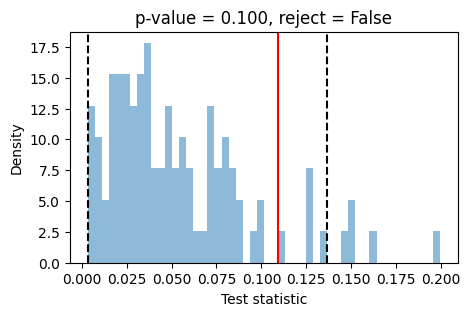

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
quantiles = np.quantile(scores_null, [0, 1-conf_alpha])
ax.hist(scores_null, bins=50, density=True, alpha=0.5, label="Null")
ax.axvline(scores_data, color="red", label="Observed")
ax.axvline(quantiles[0], color="black", linestyle="--", label="95% CI")
ax.axvline(quantiles[1], color="black", linestyle="--")
ax.set_xlabel("Test statistic")
ax.set_ylabel("Density")
ax.set_title(f"p-value = {p_value:.3f}, reject = {reject}")
plt.show()

### PP-plot to inspect over- or under-confidence

<Axes: >

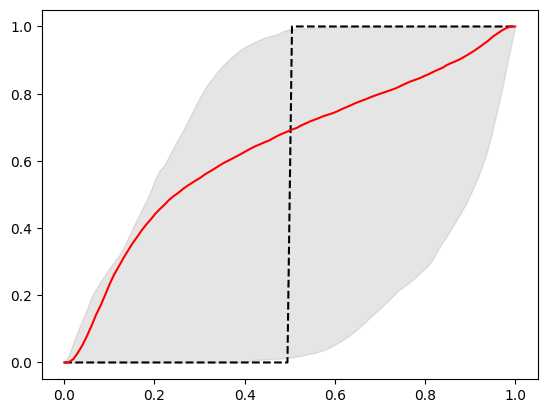

In [34]:
from sbi.analysis.plot import pp_plot_lc2st

pp_plot_lc2st(
    probs=[probs_data],
    probs_null=probs_null,
    conf_alpha=0.05,
    labels=["Classifier probabilities \n on observed data"],
    colors=["red"],
)

### Expected coverage for individual posteriors

In [7]:
for invididual in range(5):
    print("invididual", invididual)
    with open(f"../results/density_estimator_seed{invididual}.pkl", "rb") as handle:
        density_estimator = pickle.load(handle)

    prior = create_prior(as_torch_dist=True)
    posterior = DirectPosterior(density_estimator, prior)

    _ = torch.manual_seed(0)

    num_sbc_samples = 300
    prior_samples = prior.sample((num_sbc_samples,))

    p1 = create_prior()
    pars = p1.sample((1,))
    column_names = pars.columns
    parameter_set_pd = pd.DataFrame(np.asarray(prior_samples), columns=column_names)

    all_stats = []
    for i in range(num_sbc_samples):
        if i % 50 == 0:
            print("i", i)
        simulation_output = simulate(parameter_set_pd.loc[i])
        summary_statistics = summary_stats(simulation_output, stats_customization={"plateau_durations": True})
        all_stats.append(summary_statistics)
    summary_statistics = pd.concat(all_stats)
    prior_predictives = clean_data(summary_statistics.copy())
    
    from sbi.diagnostics import run_sbc
    from sbi.analysis.plot import sbc_rank_plot
    
    # run SBC: for each inference we draw 1000 posterior samples.
    num_posterior_samples = 1_000
    ranks, dap_samples = run_sbc(
        prior_samples,
        prior_predictives,
        posterior,
        reduce_fns=lambda theta, x: -posterior.log_prob(theta, x),
        num_posterior_samples=num_posterior_samples,
        use_batched_sampling=False,  # `True` can give speed-ups, but can cause memory issues.
    )
    
    with open(f"../results/analysis/individual_{invididual}_exp_cov_ranks.pkl", "wb") as handle:
        pickle.dump(ranks, handle)
    with open(f"../results/analysis/individual_{invididual}_exp_cov_dap_samples.pkl", "wb") as handle:
        pickle.dump(dap_samples, handle)

invididual 2
ERROR! Session/line number was not unique in database. History logging moved to new session 4564
i 0
i 50
i 100
i 150
i 200
i 250


Calculating ranks for 300 sbc samples.: 100%|████████████████████████████████████████████████████████████████████████████████████| 300/300 [06:13<00:00,  1.24s/it]


invididual 3
i 0
i 50
i 100
i 150
i 200
i 250


Calculating ranks for 300 sbc samples.: 100%|████████████████████████████████████████████████████████████████████████████████████| 300/300 [08:20<00:00,  1.67s/it]


invididual 4
i 0
i 50
i 100
i 150
i 200
i 250


Calculating ranks for 300 sbc samples.: 100%|████████████████████████████████████████████████████████████████████████████████████| 300/300 [08:13<00:00,  1.65s/it]
